### Load data

In [1]:
import numpy as np
import pandas as pd

# load a segmentation mask and a detection
nuceli_segmentation = np.load("data/nuclei_segmentation.npy", allow_pickle=True)
H, W = nuceli_segmentation.shape
detections = np.loadtxt("data/detections.txt", delimiter=' ', dtype=np.float32)
# detections = pd.read_csv("data/detections.txt", header=None, sep=" ")

print(f"Nuclei segmentation shape: {nuceli_segmentation.shape}")
print(f"Nuclei segmentation unique values: {len(np.unique(nuceli_segmentation))}")

display(detections)


Nuclei segmentation shape: (966, 1296)
Nuclei segmentation unique values: 243


array([[0.      , 0.454882, 0.435031, 0.011012, 0.013637],
       [0.      , 0.453682, 0.450941, 0.009459, 0.014016],
       [1.      , 0.309761, 0.436488, 0.008104, 0.010379],
       [1.      , 0.283053, 0.454033, 0.00921 , 0.01285 ],
       [1.      , 0.248424, 0.461941, 0.012157, 0.01285 ]], dtype=float32)

### Extract the countour

27289


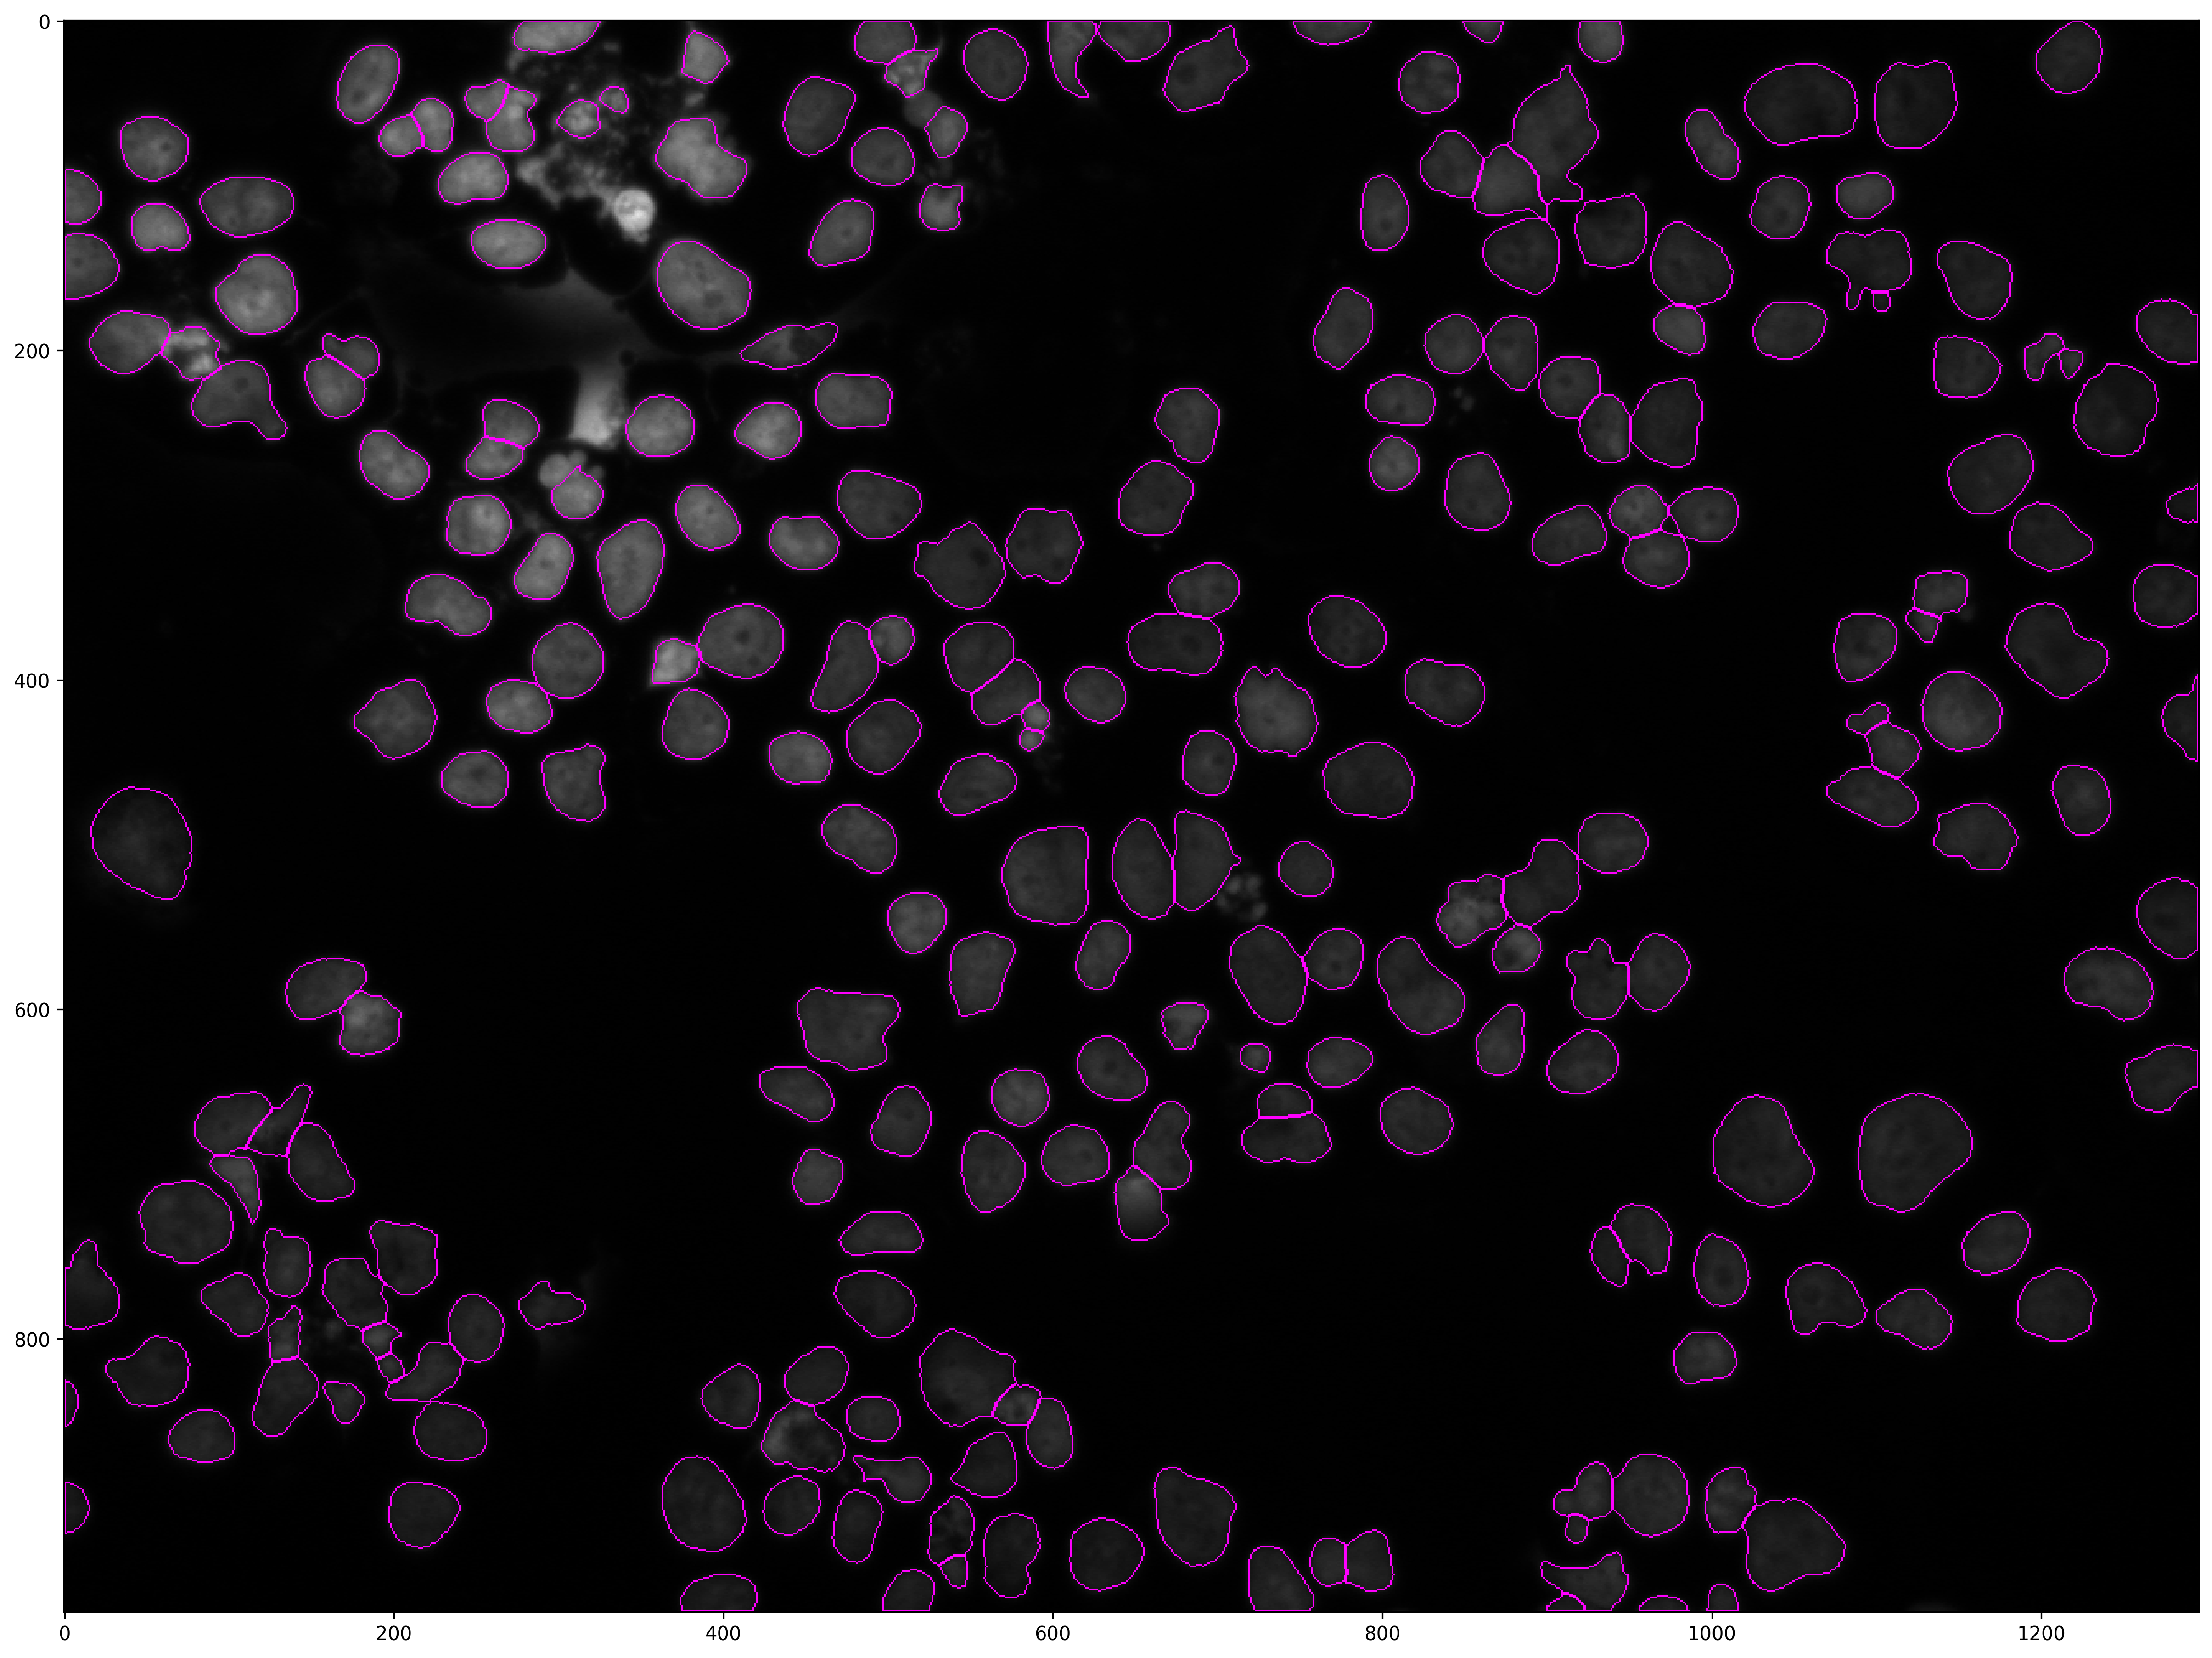

In [2]:
def find_contour_points(L):
    """
    Find the contour points of the nuclei. A point belongs the by shifting the nuclei_segmetnation matrix by 1 pixel in all directions
    the entry changes.
    """

    up = np.zeros_like(L); up[1:, :] = L[:-1, :]
    down = np.zeros_like(L); down[:-1, :] = L[1:, :]
    left = np.zeros_like(L); left[:, 1:] = L[:, :-1]
    right = np.zeros_like(L); right[:, :-1] = L[:, 1:]

    is_boundary = (
        (L != 0) & ( (up != L) | (down != L) | (left != L) | (right != L) )
    )

    xs, ys = np.nonzero(is_boundary)
    if xs.size == 0:
        return np.empty((0,2), dtype=np.int32), np.empty((0,), dtype=L.dtype)

    labs = L[xs, ys]
    coords = np.stack([xs.astype(np.int32), ys.astype(np.int32)], axis=1)
    return coords, labs

coords, labs = find_contour_points(nuceli_segmentation)
print(len(coords))
# visualize the countour points
import skimage
from matplotlib import pyplot as plt
img = skimage.io.imread("data/image.tif")
img = skimage.img_as_ubyte(img)
img = np.dstack((img, img, img))
# plot the contour points in magenta
img_contour = img.copy()
for c in coords:
    img_contour[c[0], c[1], :] = (255, 0, 255)
# increease figure size
plt.figure(figsize=(20, 20), dpi=300)    
plt.imshow(img_contour)
plt.show()


### Generate KD-Tree

Time taken to build the KD-Tree: 0.013277053833007812 seconds
xc: 420, yc: 589
Distance: 5.385164807134504, Index: 12952
Time taken to find the nearest neighbor: 0.00031685829162597656 seconds


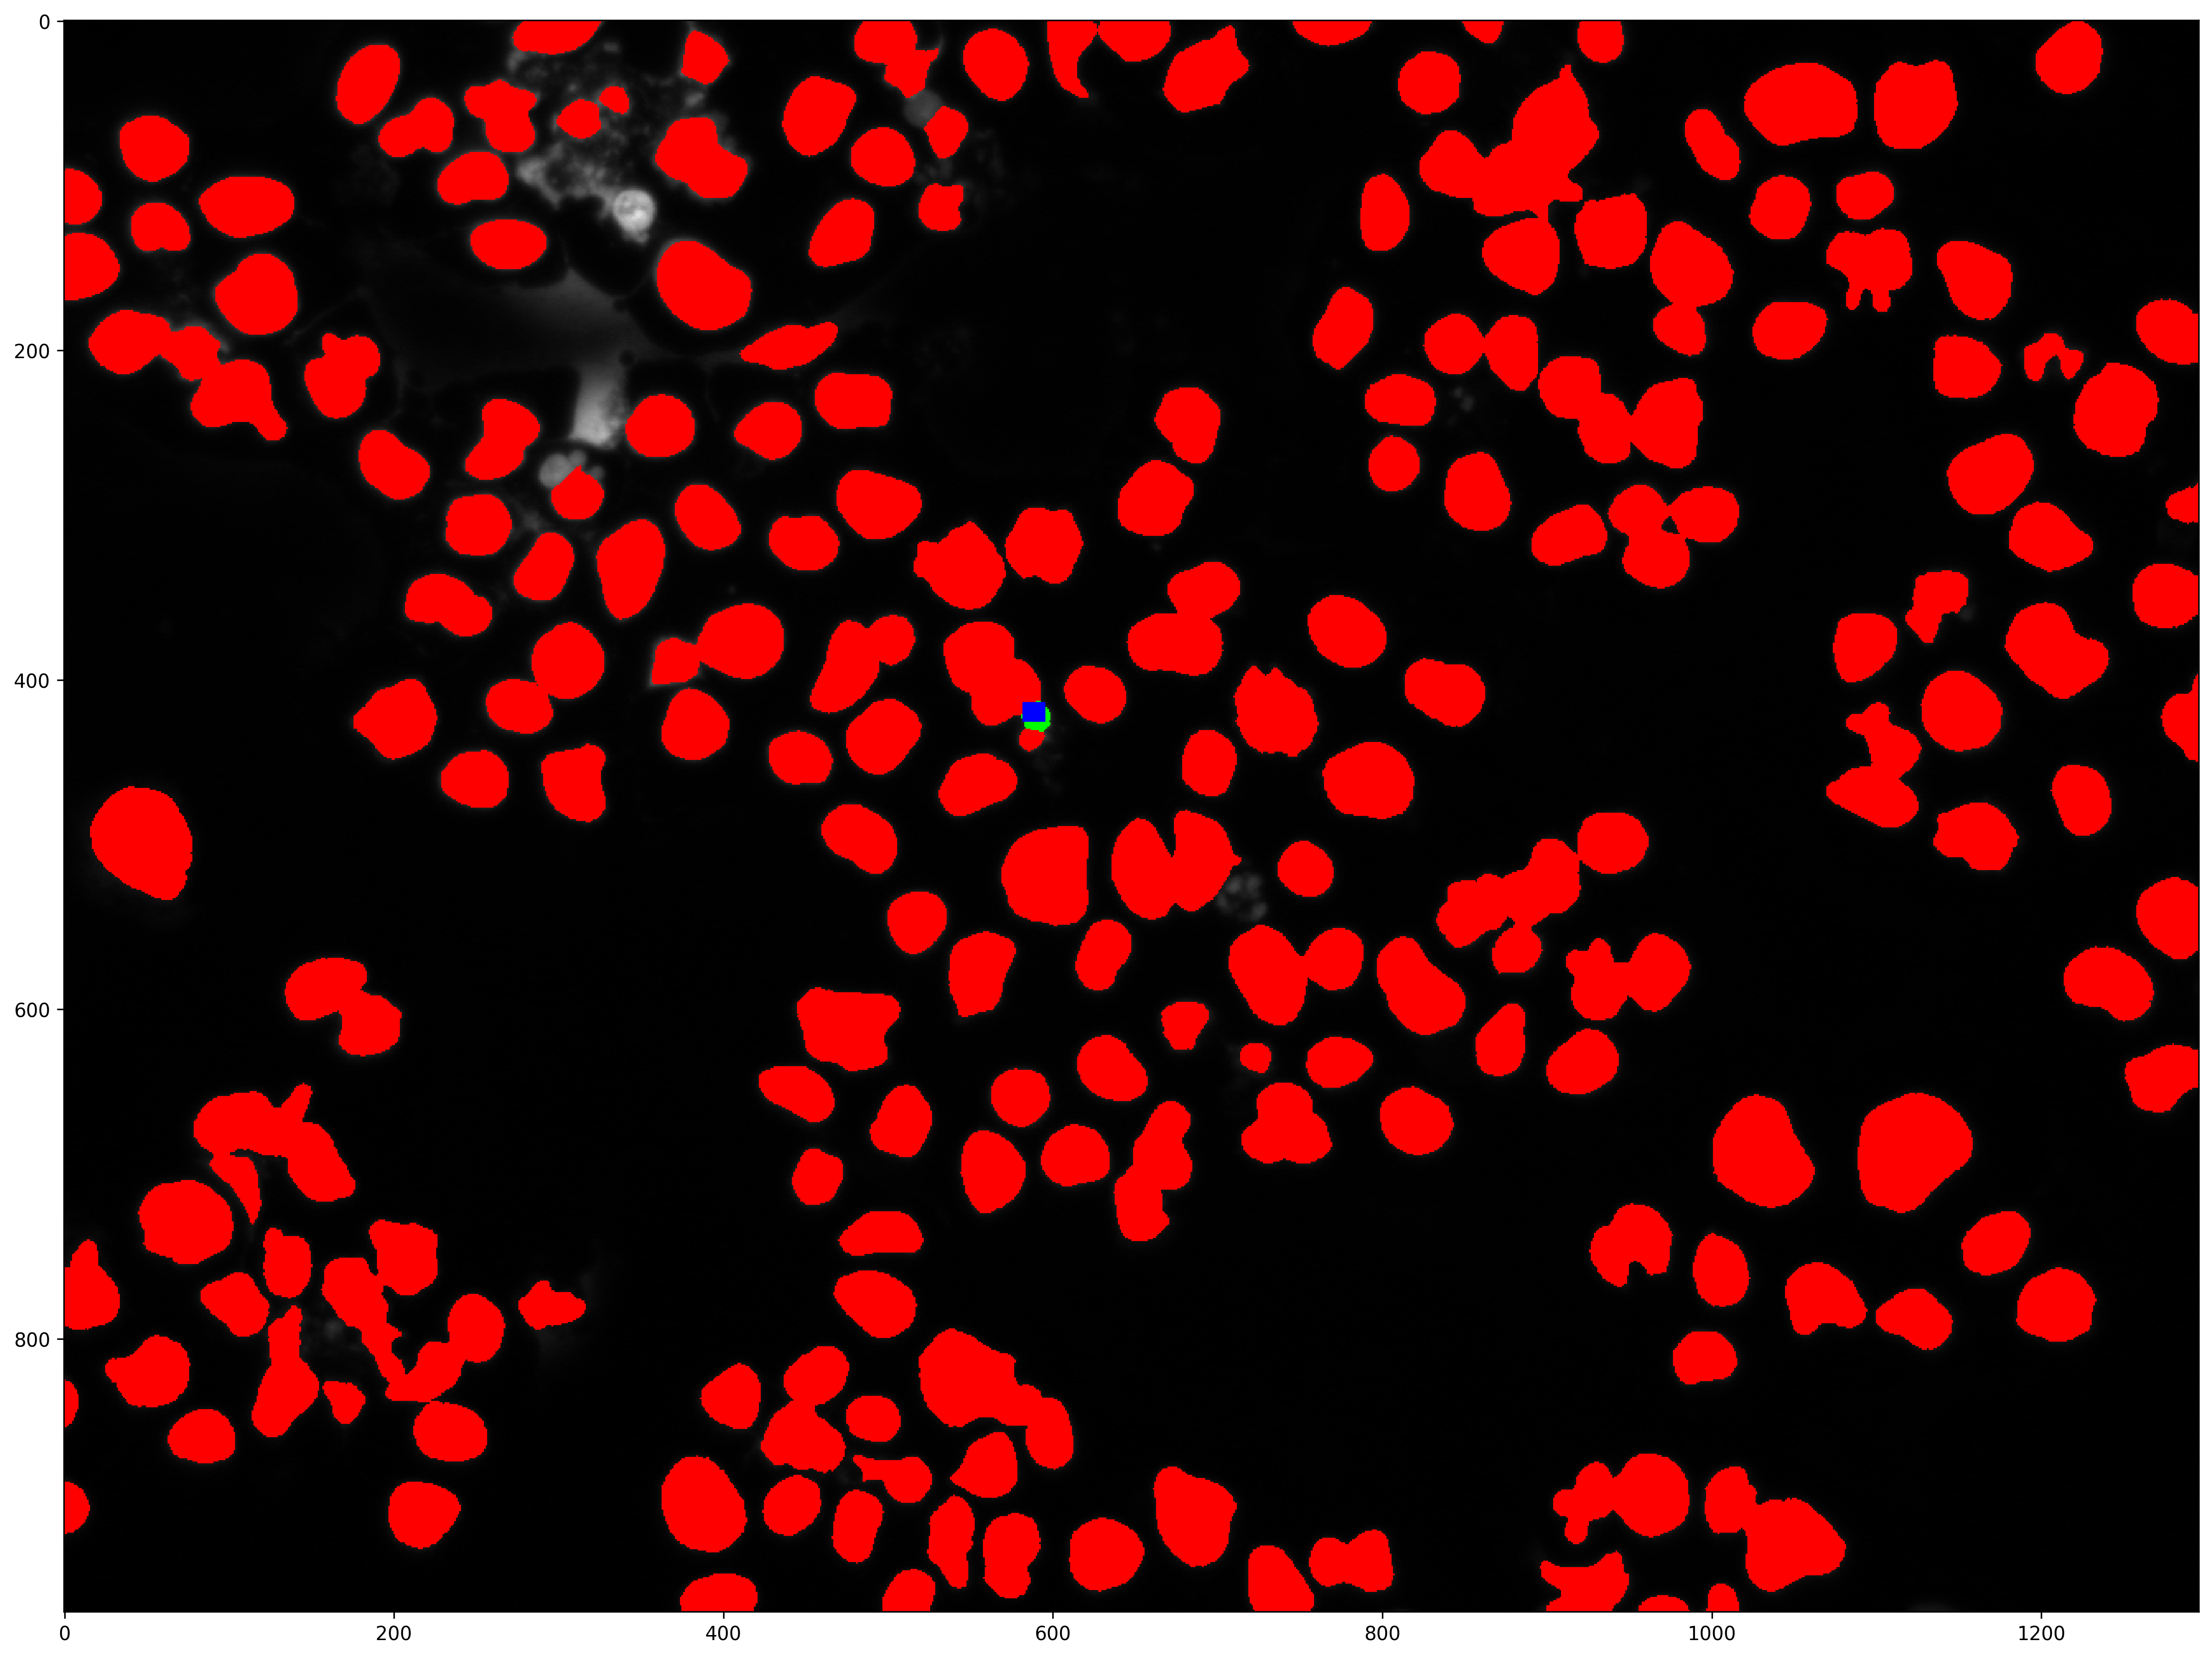

xc: 435, yc: 587
Distance: 4.0, Index: 13451
Time taken to find the nearest neighbor: 0.00017571449279785156 seconds


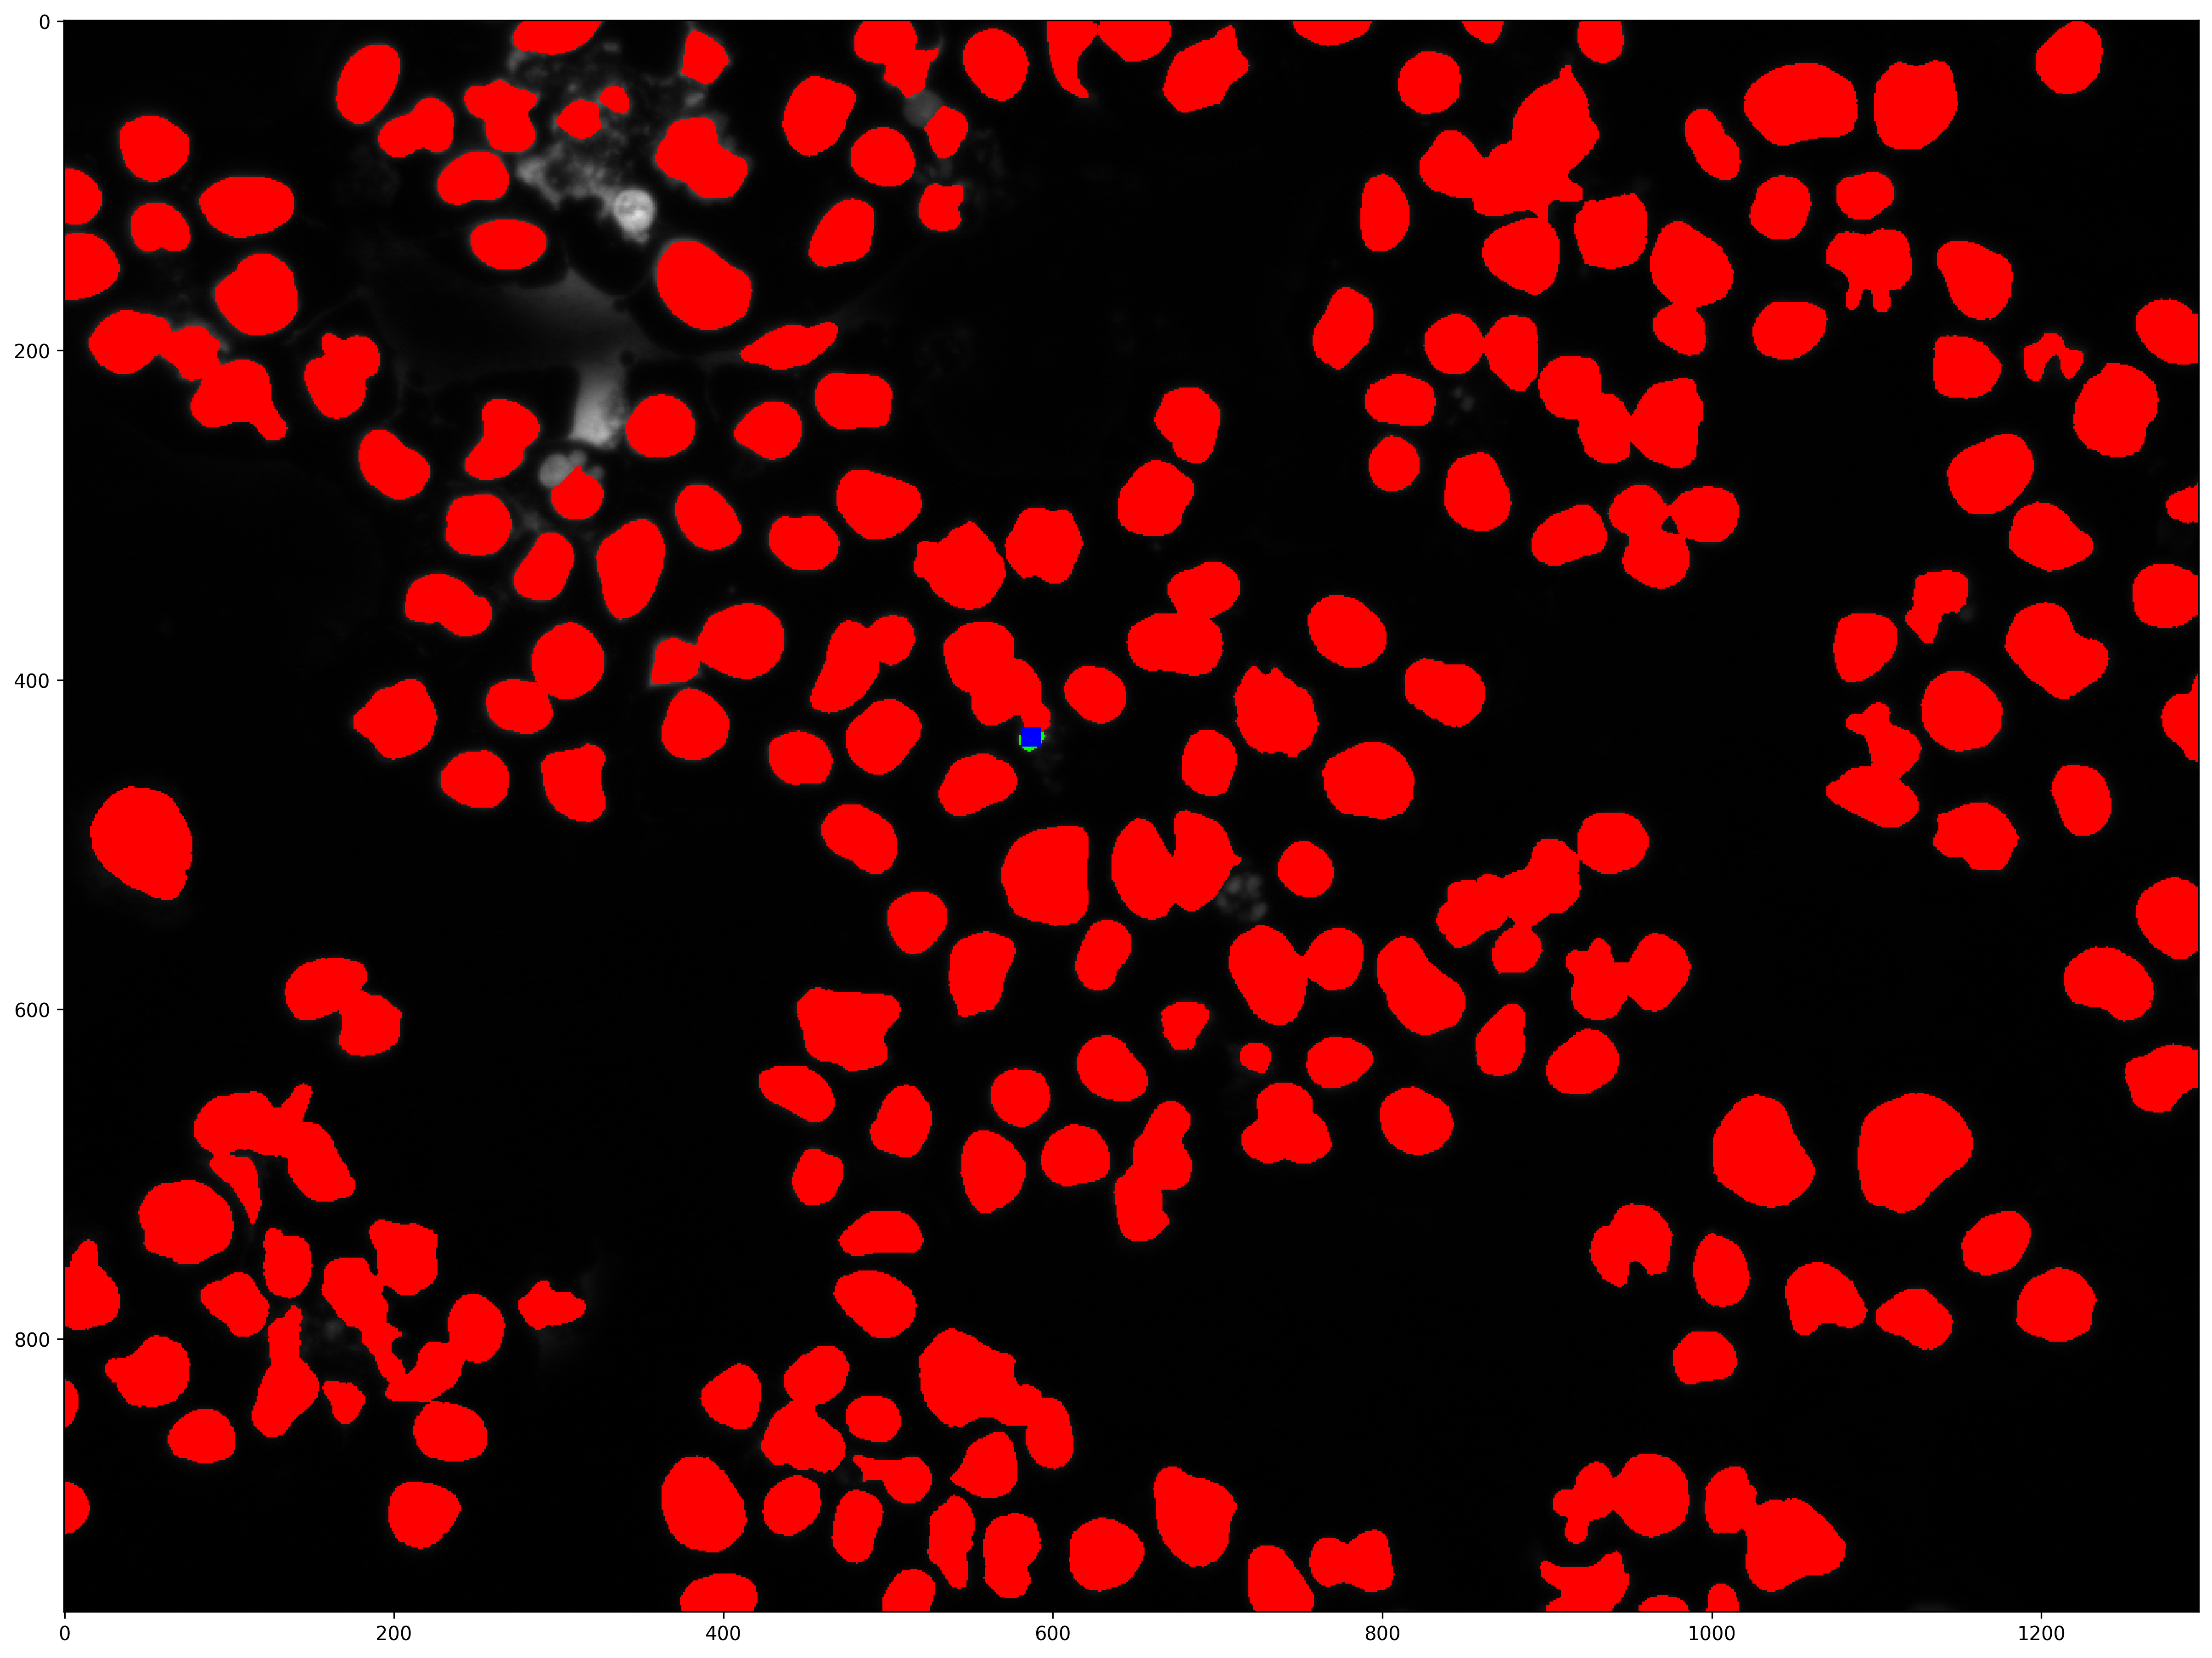

xc: 421, yc: 401
Distance: 0.0, Index: 13123
Time taken to find the nearest neighbor: 0.00014710426330566406 seconds


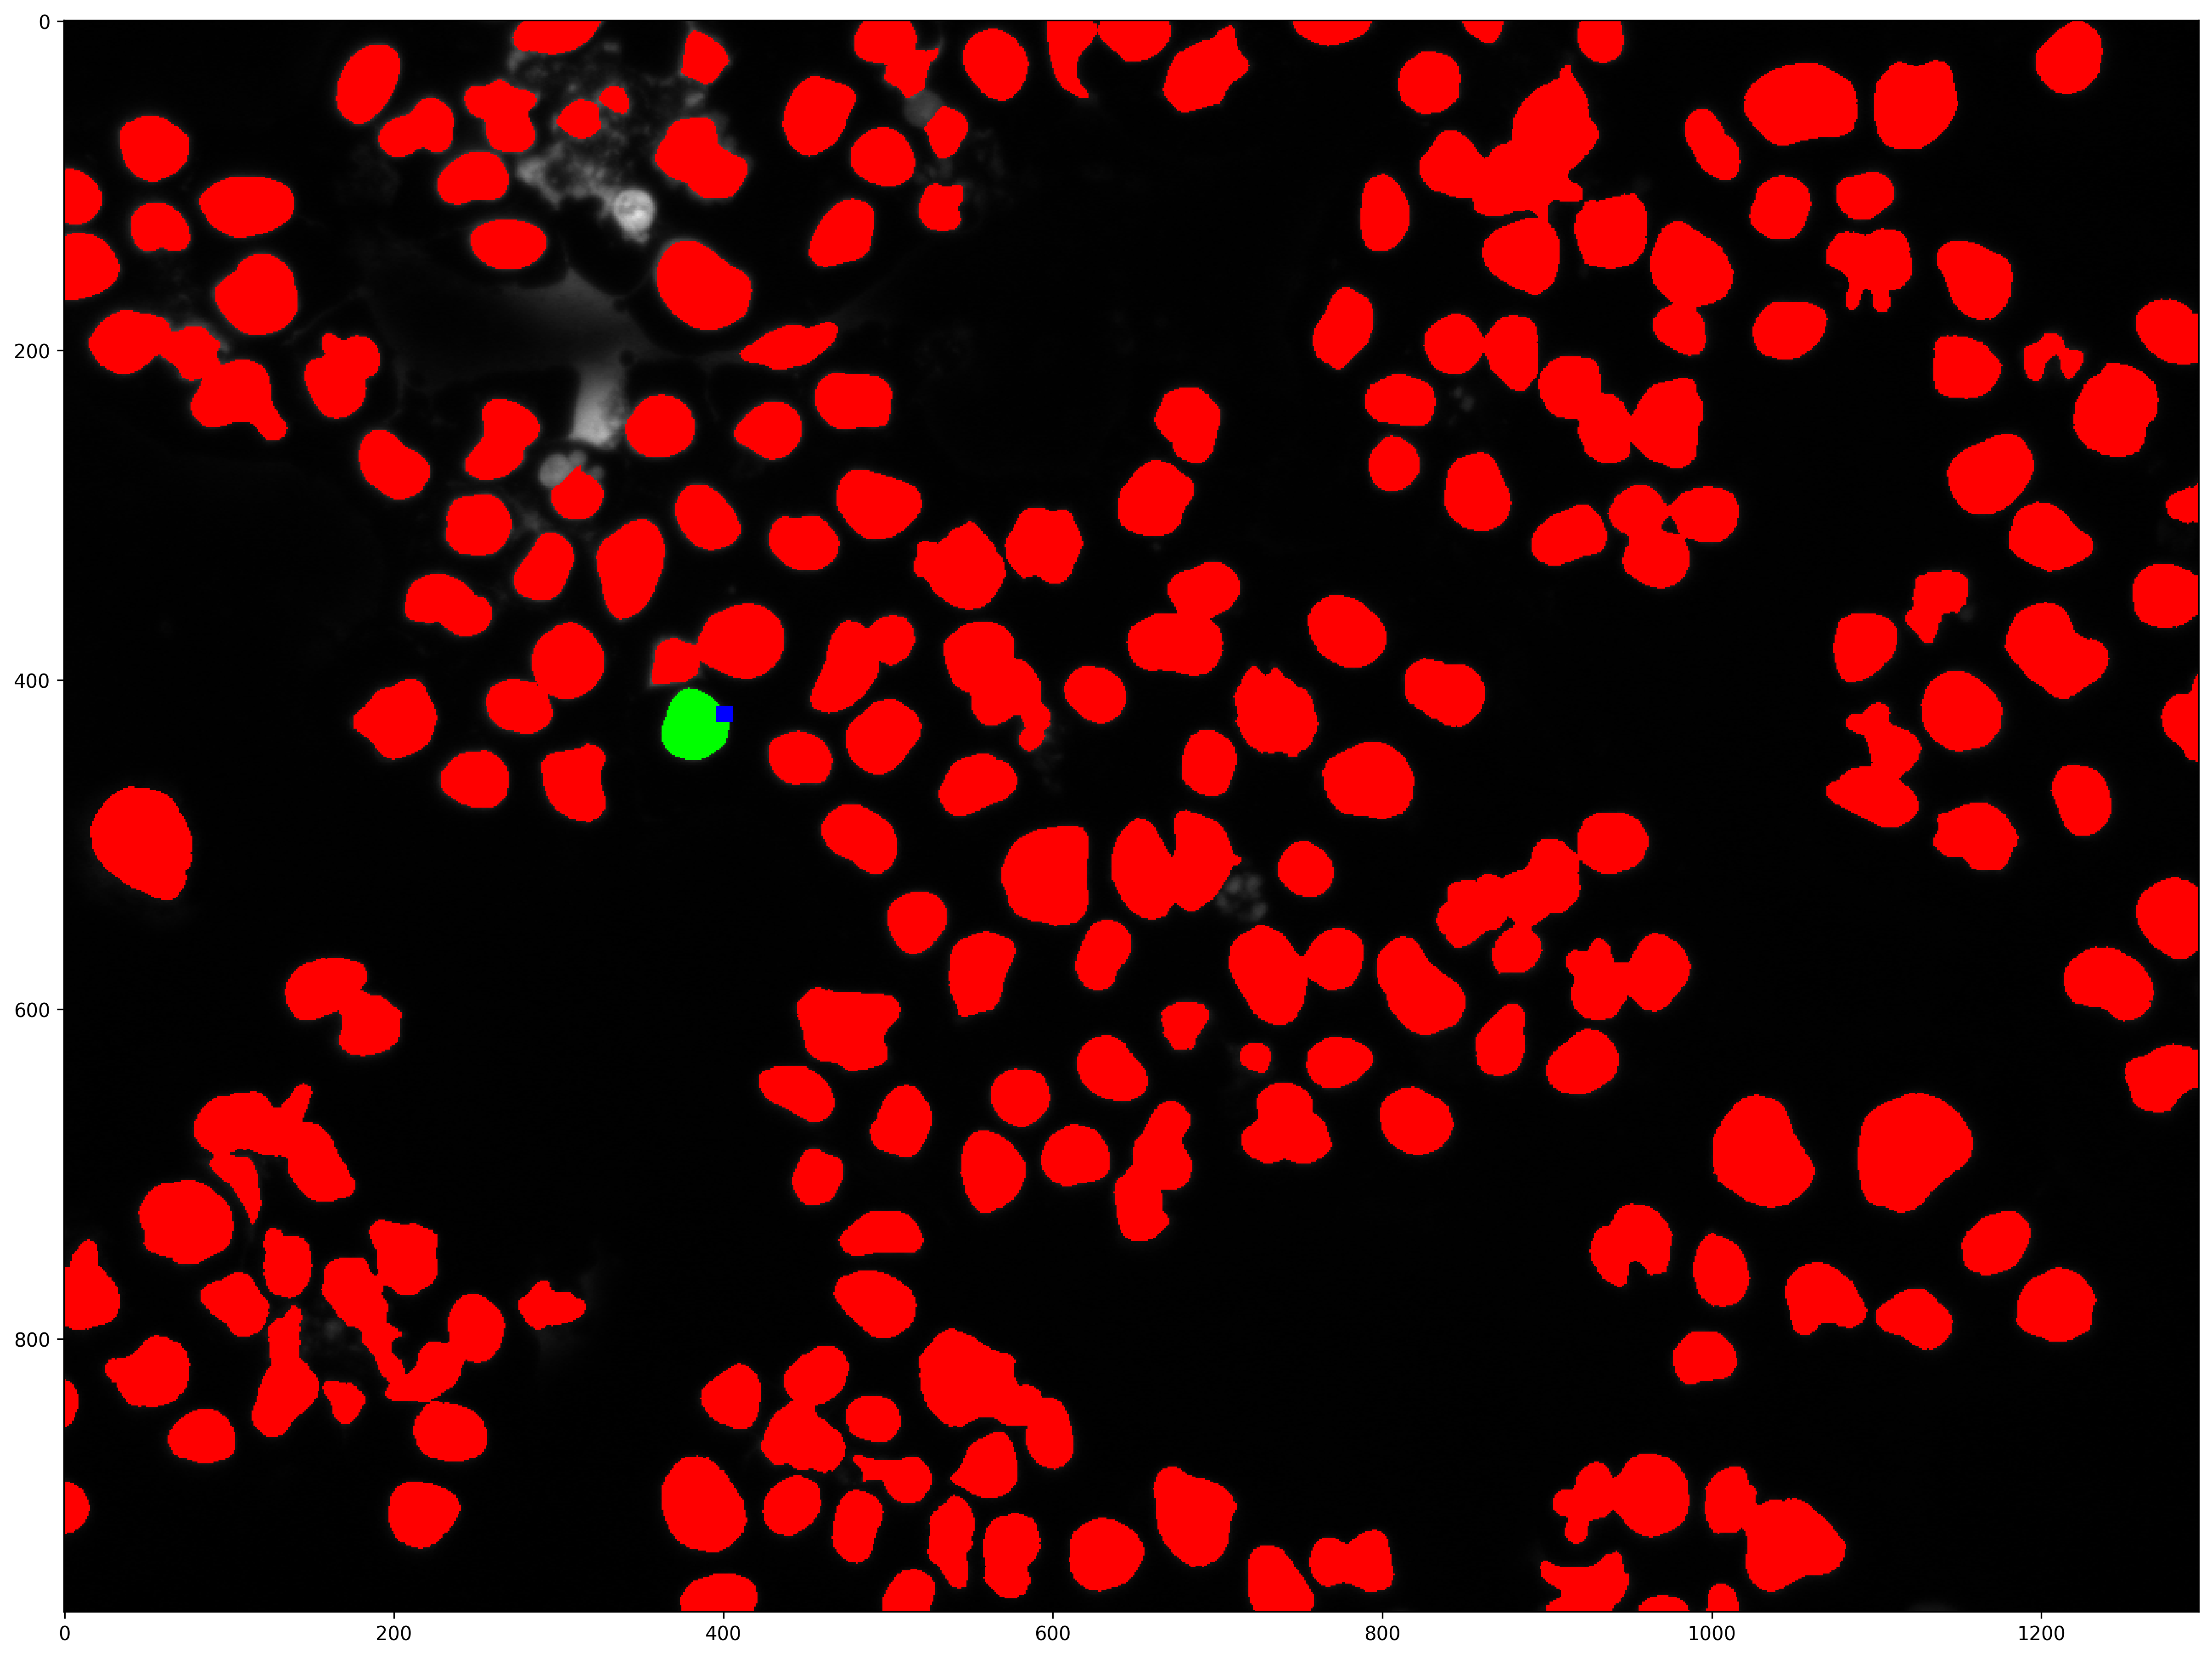

xc: 438, yc: 366
Distance: 2.0, Index: 13647
Time taken to find the nearest neighbor: 9.584426879882812e-05 seconds


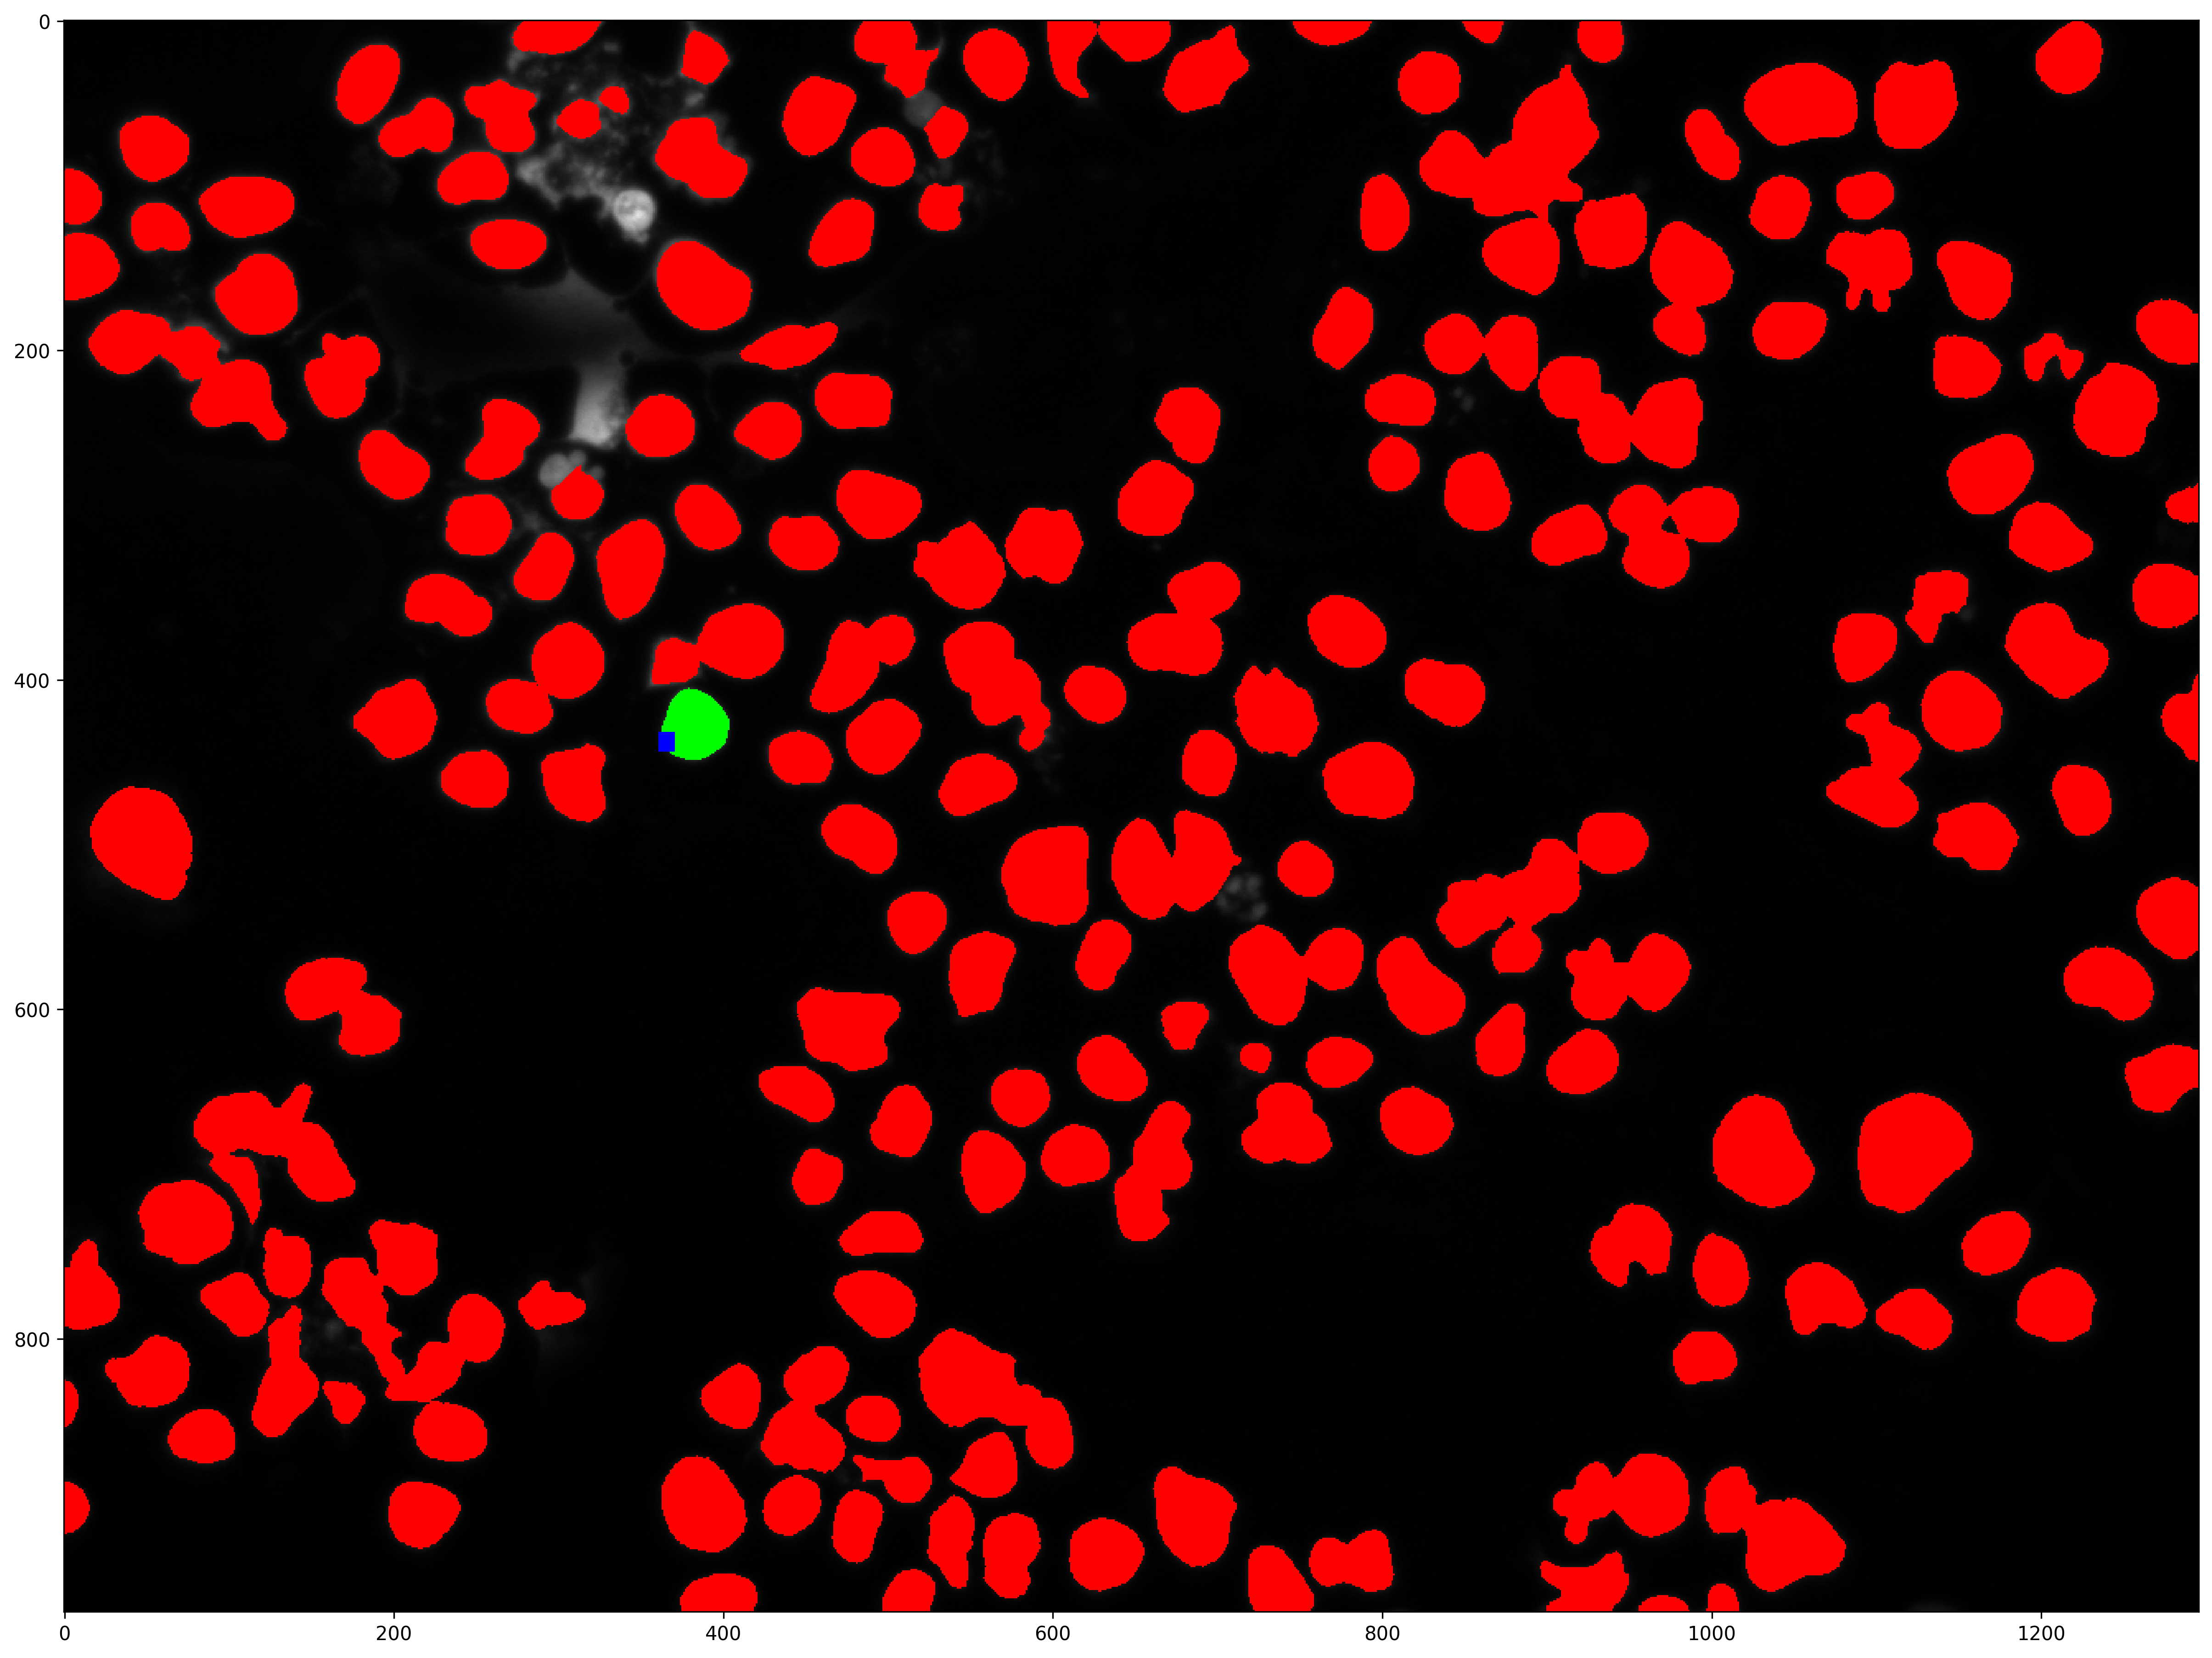

xc: 446, yc: 321
Distance: 5.385164807134504, Index: 13743
Time taken to find the nearest neighbor: 0.00015211105346679688 seconds


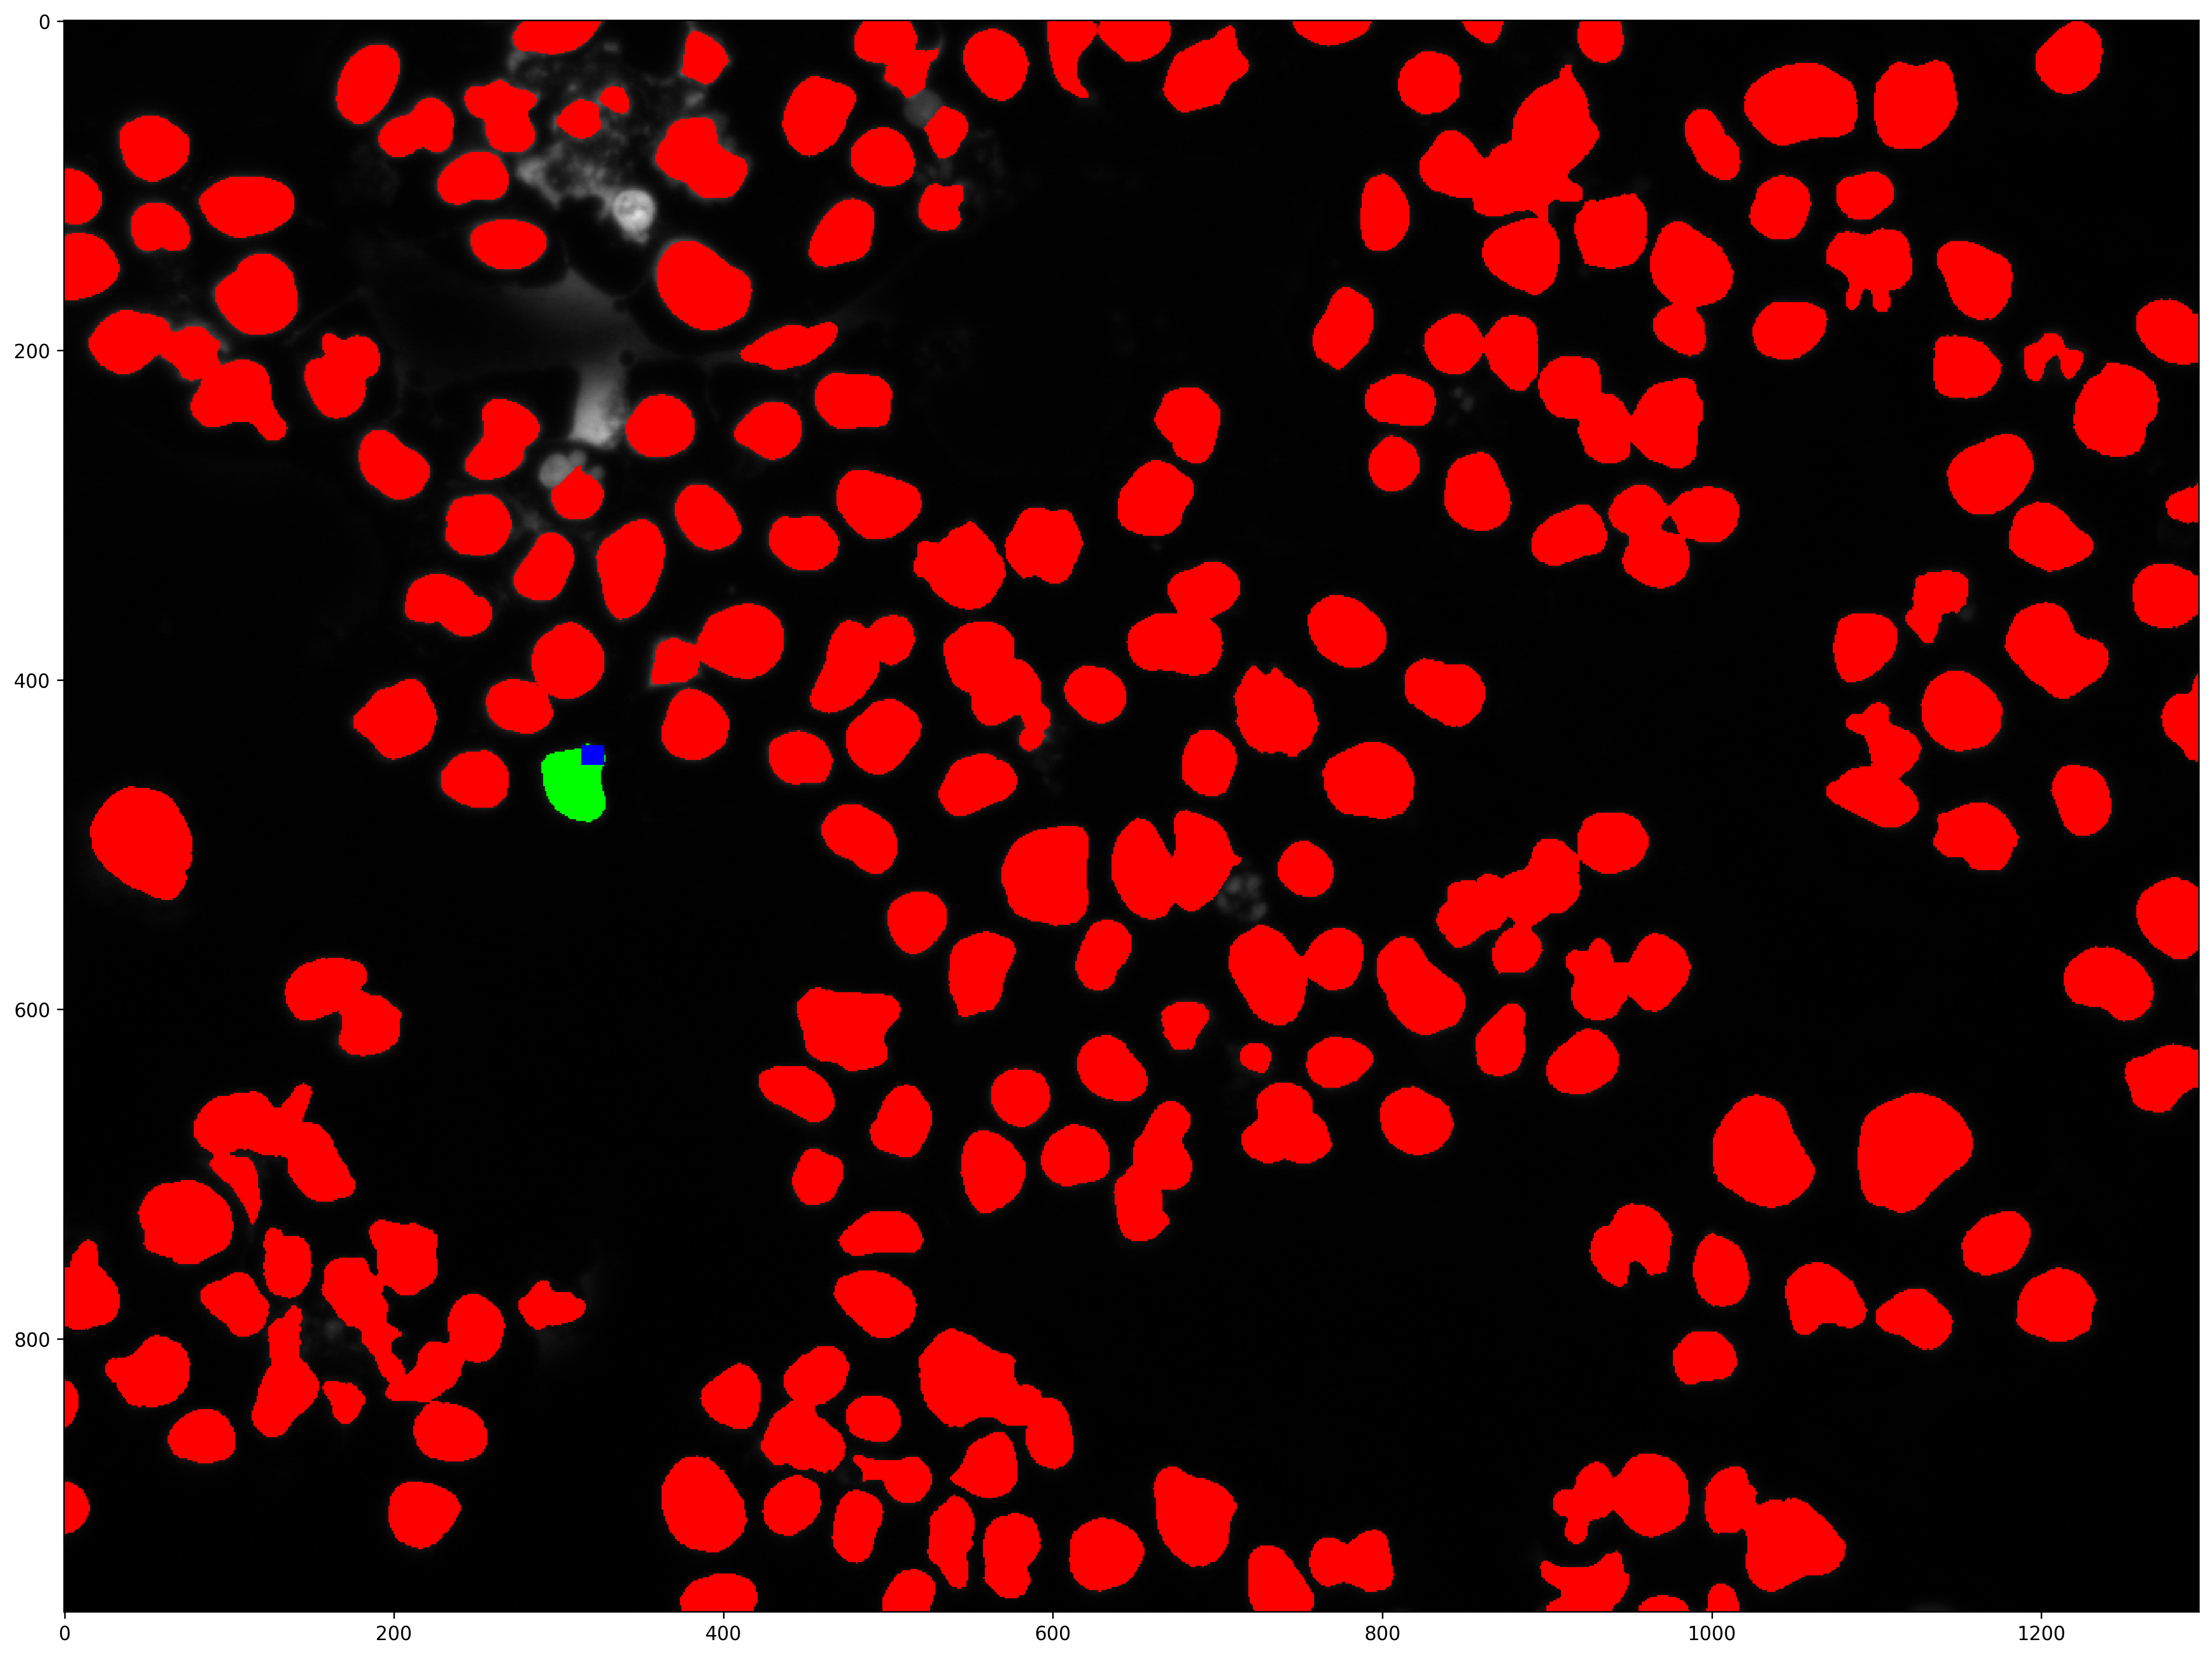

In [9]:
from scipy.spatial import KDTree
import time

start = time.time()
tree = KDTree(coords)
end = time.time()
print(f"Time taken to build the KD-Tree: {end - start} seconds")

### Find the nearest neighbors of the bounding box centers
for r in detections:
    xc, yc = int(r[2]*H), int(r[1]*W)
    print(f"xc: {xc}, yc: {yc}")
    time_start = time.time()
    dist, idx = tree.query([[xc, yc]], k=1)
    lab = labs[idx[0]]
    time_end = time.time()
    print(f"Distance: {dist[0]}, Index: {idx[0]}")
    print(f"Time taken to find the nearest neighbor: {time_end - time_start} seconds")

    # print the box, the segmented nuceli and the nearest neighbo
    img_temp = img.copy()
    # plot the segmented nuclei
    img_temp[np.nonzero(nuceli_segmentation)] = (255, 0, 0)
    img_temp[nuceli_segmentation == lab] = (0, 255, 0)
    h, w = r[4]*H, r[3]*W
    img_temp[int(xc-h//2):int(xc+h//2), int(yc-w//2):int(yc+w//2)] = (0, 0, 255)
    plt.figure(figsize=(20, 20), dpi=300)    
    plt.imshow(img_temp)
    plt.show()
    
    



In [ ]:
data = [[0, 0, 0],
[1, 0, 0],
[2, 0, 1],
[3, 1, 0],
[4, 0, 1],
[5, 2, 0],
[6, 1, 0],
[7, 0, 3],]
postprocessed_detections = pd.DataFrame(data, columns=["nucleus_id", "micro_nuclei", "nuclear_buds"])
display(postprocessed_detections)

print(postprocessed_detections[postprocessed_detections["micro_nuclei"] == 1].shape[0])
print(postprocessed_detections["nucleus_id"].nunique())

nucleus_id  micro_nuclei  nuclear_buds
0           0             0             0
1           1             0             0
2           2             0             1
3           3             1             0
4           4             0             1
5           5             2             0
6           6             1             0
7           7             0             3

2
8


In [ ]:
df = pd.DataFrame(columns=["image_id", "micro_nuclei_count"])
df.loc[0] = ["images_1/29.11.24 6dpi_BC587 0.1mM NR 1_RAW_ch00.tif", 2.0]
print(df['image_id'].values)
print("images_1/29.11.24 6dpi_BC587 0.1mM NR 1_RAW_ch00.tif" in df['image_id'].values)

['images_1/29.11.24 6dpi_BC587 0.1mM NR 1_RAW_ch00.tif']
True
